# Trabajo de Fin de Grado: Dog Finder

El presente notebook muestra cómo funciona el sistema  de reconocimiento de imagenes de perros perdidos utilizando Transferencia de Aprendizaje con MobileNetV2 y una base de datos SQLite.

## Resumen del Flujo del Programa

1. **Configuración inicial**
2. **Importar Bibliotecas**: Se importan todas las bibliotecas necesarias.
3. **Definir Modelo de Reconocimiento**: Se define la clase *DogRecognitionModel* para extraer características de las imágenes usando MobileNetV2.
4. **Definir la Base de Datos**: Se define la estructura de la base de datos con SQLAlchemy.
5. **Registro automático de imagenes en la base de datos**: Se procesan y registran las imágenes de un directorio en la base de datos.
8. **Realizar Búsqueda de Prueba**: Se realiza una búsqueda de ejemplo para demostrar cómo funciona el sistema.

## 1. Configuración incial

Instalar las dependencias necesarias 

In [47]:
pip install tensorflow opencv-python pillow sqlalchemy matplotlib

Note: you may need to restart the kernel to use updated packages.


## 2. Importar Bibliotecas:

- ```os```: Para interactuar con el sistema operativo (por ejemplo, para trabajar con rutas de archivos).
- ```numpy (np)```: Para operaciones numéricas eficientes, especialmente con arreglos.
- ```tensorflow (tf)```: La biblioteca principal para construir y entrenar modelos de aprendizaje profundo.
- ```cv2 (OpenCV)```: Para procesamiento de imágenes (leer, escribir, manipular).
- ```tensorflow.keras.applications.MobileNetV2```: Un modelo de red neuronal pre-entrenado para la extracción de características de imágenes.
- ```tensorflow.keras.applications.mobilenet_v2.preprocess_input```: Función para preprocesar imágenes para MobileNetV2.
- ```tensorflow.keras.models.Model```: Para definir modelos en TensorFlow/Keras.
- ```sqlalchemy```: Una biblioteca para interactuar con bases de datos relacionales (en este caso, SQLite).
- ```datetime```: Para trabajar con fechas y horas.
- ```json```: Para trabajar con datos en formato JSON (usado para almacenar características de imágenes).
- ```matplotlib.pyplot (plt)```: Para visualizar imágenes y otros gráficos.

In [50]:
import os 
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from sqlalchemy import create_engine, Column, Integer, String, DateTime
from sqlalchemy.orm import declarative_base
from sqlalchemy.orm import sessionmaker
from datetime import datetime
import json
import matplotlib.pyplot as plt

## Definir Modelo de Reconocimiento

La clase DogRecognitionModel
- Implementa de manera competente una pipeline para la extracción de características de imágenes utilizando la arquitectura eficiente MobileNetV2 y la técnica de aprendizaje por transferencia
- Carga un modelo pre-entrenado en ImageNet, lo adapta para la extracción de características congelando sus pesos y eliminando la capa de clasificación
- Aplica preprocesamiento estándar de imágenes (carga, conversión de color, redimensionamiento) y normalización específica del modelo
- Genera un vector de características L2 normalizado de 1280 dimensiones para cada imagen de entrada.

In [53]:
class DogRecognitionModel:
    def __init__(self):
        # Inicialización del modelo base (MobileNetV2)
        # Usamos el modelo pre-entrenado en ImageNet
        # Eliminamos la capa de clasificación (include_top=False)
        # Aplicamos pooling global para obtener un vector de características
        base_model = MobileNetV2(
            input_shape=(224, 224, 3),  # Tamaño estándar para MobileNetV2
            include_top=False,          # Sin capa de clasificación - ndica si se debe incluir la capa completamente conectada 
            pooling='avg',              # Pooling global para obtener vector
            weights='imagenet'          # Pesos pre-entrenados
        )
        # Congelamos los pesos para usar solo como extractor
        base_model.trainable = False
        
        # Definir el modelo extractor
        self.feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)
    
    def preprocess_image(self, image_path):
        # 1. Cargar imagen con OpenCV
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f'No se pudo cargar la imagen: {image_path}')
            
        # 2. Convertir de BGR a RGB (OpenCV usa BGR por defecto)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # 3. Redimensionar a 224x224 (tamaño requerido por MobileNetV2)
        img = cv2.resize(img, (224, 224))
        
        # 4. Convertir a float32 para procesamiento
        img = img.astype('float32')
        
        # 5. Expandir dimensiones para batch (modelo espera batch)
        img = np.expand_dims(img, axis=0)
        
        # 6. Preprocesar para MobileNetV2 (normaliza a [-1,1])
        return preprocess_input(img)
    
    def extract_features(self, image):
        # 1. Extraer características usando el modelo
        features = self.feature_extractor.predict(image, verbose=0)
        
        # 2. Normalizar el vector (importante para comparación coseno)
        # Dividimos por la norma para obtener un vector unitario
        features = features / np.linalg.norm(features)
        
        return features
    
    def process_image(self, image_path):
        # Método de conveniencia que combina preprocesamiento y extracción
        img = self.preprocess_image(image_path)
        return self.extract_features(img)

## Definir la Base de Datos

### Diseño de la Base de Datos
Utilizamos SQLite con SQLAlchemy como ORM por las siguientes razones:
- Fácil configuración y portabilidad
- No requiere servidor separado
- Ideal para desarrollo y pruebas
- Soporte para almacenar vectores de características como JSON

### Configuración de la base de datos con SQLAlchemy

In [56]:
# Se crea una clase base declarativa. Todas las clases que representen tablas en la base de datos heredarán de esta clase
Base = declarative_base()

# Se define una clase llamada Dog que hereda de Base, lo que la convierte en un modelo para una tabla de la base de datos.
class Dog(Base):
    """Modelo para almacenar información de perros y sus características"""
    # Se especifica que esta clase se mapeará a una tabla llamada dogs en la base de datos.
    __tablename__ = 'dogs'
    
    id = Column(Integer, primary_key=True)
    name = Column(String(100), nullable=True)         # Nombre opcional
    location = Column(String(500), nullable=False)    # Ubicación donde se encontró
    found_date = Column(DateTime, nullable=False)     # Fecha de registro
    image_path = Column(String(1000), nullable=False) # Ruta a la imagen
    features = Column(String, nullable=False)         # Vector de características en JSON

# Crear base de datos
# Se define la ruta a la base de datos SQLite.
# En este caso, se creará un archivo llamado dog_finder_demo_v3.db  
# El prefijo sqlite:/// indica que se está utilizando una base de datos SQLite.
db_path = 'sqlite:///dog_finder_demo_v3.db'
engine = create_engine(db_path)  #Se crea un "motor" de SQLAlchemy. El motor es la interfaz principal para la base de datos y maneja la conexión.
Base.metadata.create_all(engine)  # Este comando crea las tablas definidas en los modelos (en este caso, la tabla dogs) en la base de datos especificada por el engine, si aún no existen.

# Crear sesión para interactuar con la BD

#Se crea una fábrica de sesiones. Una sesión de SQLAlchemy proporciona una forma de interactuar con la base de datos, permitiendo realizar operaciones como 
# agregar, eliminar, modificar y consultar datos. Se vincula la fábrica de sesiones al engine de la base de datos.
Session = sessionmaker(bind=engine) 
session = Session() #Se crea una instancia de la sesión. A través de este objeto session, se realizarán todas las operaciones en la base de datos.


### Registro automático de imagenes en la base de datos

Se registran automáticamente las imagenes que se encuentran en la carpeta test_images

In [59]:
# Inicializar modelo de reconocimiento
model = DogRecognitionModel()

def is_duplicate_image(new_features, threshold=0.999):  # Umbral alto para "exacto"
    """
    Verifica si una imagen (representada por sus características) ya existe en la base de datos.

    Args:
        new_features: El vector de características de la nueva imagen.
        threshold: El umbral de similitud para considerar una imagen como duplicada.

    Returns:
        True si la imagen es un duplicado, False en caso contrario.
    """
    for dog in session.query(Dog).all():
        db_features = np.array(json.loads(dog.features))
        similarity = float(np.dot(new_features.flatten(), db_features.flatten()))
        if similarity > threshold:
            return True
    return False

#SUPONGO QUE ESTO CAMBIARA CUANDO LA CARPETA NO SE ENCUENTRE EN LOCAL SINO EN GITHUB

test_images_dir = '../test_images'  # se define la ruta al directorio donde se espera encontrar las imágenes de prueba.
if os.path.exists(test_images_dir):  # Se verifica si el directorio existe.
    print(f'Registrando imágenes de {test_images_dir}...')
    count = 0
    for fname in os.listdir(test_images_dir):  # Se itera sobre todos los archivos y directorios dentro del directorio test_images_dir
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):  # Se verifica si el nombre del archivo termina con las extensiones de imagen comunes (.jpg, .jpeg, .png), ignorando las mayúsculas.
            img_path = os.path.join(test_images_dir, fname)  # Se construye la ruta completa al archivo de la imagen.
            try:  # Se utiliza un bloque try-except para manejar posibles errores durante el procesamiento de cada imagen.

                # Extraer características
                # Se llama al método process_image del objeto model (la instancia de DogRecognitionModel) para extraer las características de
                # la imagen ubicada en img_path. Se espera que este método devuelva un vector de características.
                features = model.process_image(img_path)

                # Verificar si la imagen es un duplicado
                if not is_duplicate_image(features):
                    # Convertir a JSON para almacenamiento
                    # El vector de características (probablemente un array de NumPy) se convierte primero a una lista y luego a una cadena JSON
                    # para poder almacenarlo en la columna features de la base de datos.
                    features_json = json.dumps(features.tolist())

                    # Crear registro en la base de datos
                    dog = Dog(
                        name=fname,  # Usamos nombre de archivo
                        location='Desconocida',  # Ubicación genérica
                        found_date=datetime.now(),
                        image_path=img_path,
                        features=features_json
                    )

                    # Guardar en la base de datos
                    session.add(dog)  # Se agrega el nuevo objeto Dog a la sesión de SQLAlchemy, lo que lo marca para ser insertado en la base de datos.
                    session.commit()  # Se confirman los cambios pendientes en la sesión y se escriben en la base de datos.
                    count += 1  # Se incrementa un contador de imágenes registradas.
                    print(f'Registrada imagen: {fname}')
                else:
                    print(f'Imagen {fname} es un duplicado, no se agregó.')

            except Exception as e:
                print(f'Error con {fname}: {e}')

    print(f'Total de imágenes registradas: {count}')
else:
    print(f'¡Advertencia! No se encontró el directorio {test_images_dir}')


Registrando imágenes de ../test_images...
Imagen beagle2.jpeg es un duplicado, no se agregó.
Imagen weimaraner1.jpg es un duplicado, no se agregó.
Imagen beagle3.jpeg es un duplicado, no se agregó.
Imagen Lummi2.jpeg es un duplicado, no se agregó.
Imagen corgi1.jpg es un duplicado, no se agregó.
Imagen Maya1.jpeg es un duplicado, no se agregó.
Imagen Lucy.jpg es un duplicado, no se agregó.
Imagen dalmatamix2.jpeg es un duplicado, no se agregó.
Imagen beagleprueba.jpeg es un duplicado, no se agregó.
Imagen Lucy2.jpg es un duplicado, no se agregó.
Imagen beagleMix.jpeg es un duplicado, no se agregó.
Imagen dalmata.jpeg es un duplicado, no se agregó.
Imagen beagleOld.jpeg es un duplicado, no se agregó.
Imagen Maya2.jpeg es un duplicado, no se agregó.
Imagen dalmataMix1.jpeg es un duplicado, no se agregó.
Imagen Lummi1.jpeg es un duplicado, no se agregó.
Imagen golden2.jpg es un duplicado, no se agregó.
Imagen beaglemix2.jpeg es un duplicado, no se agregó.
Imagen golden1.jpg es un duplicad

In [61]:
# Mostrar el total de imágenes en la base de datos
total_images = session.query(Dog).count()
print(f"\nTotal de imágenes en la base de datos: {total_images}")


Total de imágenes en la base de datos: 20


### Resetear BD cuando ejecutas muchas veces el codigo anterior

In [ ]:
def reset_database():
    """Borra todos los registros de la tabla 'dogs'."""
    session.query(Dog).delete()
    session.commit()
    print("Base de datos reiniciada.")

reset_database()

## 4. Pruebas de Búsqueda

Ahora vamos a probar el sistema buscando perros similares a una imagen de prueba.
El proceso es el siguiente:
1. Seleccionamos una imagen de prueba
2. Extraemos sus características
3. Comparamos con todas las imágenes en la base de datos
4. Mostramos los resultados ordenados por similitud

### Función para mostrar imágen
La función show_image toma la ruta de una imagen, la carga, la convierte al formato de color correcto, la muestra en una ventana y, opcionalmente, le agrega un título. Es una función de utilidad que simplifica la visualización de imágenes en el programa.

In [64]:
# Función para mostrar imágenes
def show_image(image_path, title=None): #Define una función llamada show_image que toma la ruta de una imagen (image_path) y un título opcional (title) como argumentos.
    
    """Muestra una imagen usando matplotlib"""
    #Utiliza la función imread de la librería cv2 (OpenCV) para leer la imagen desde la ruta especificada y la almacena en la variable img. 
    # OpenCV lee las imágenes en formato BGR (Azul, Verde, Rojo).
    img = cv2.imread(image_path)
    if img is None:  #Verifica si la imagen se cargó correctamente. 
        print(f'No se pudo cargar la imagen: {image_path}')
        return

    # Convierte el espacio de color de la imagen de BGR a RGB (Rojo, Verde, Azul). 
    # Matplotlib, que se utilizará para mostrar la imagen, espera las imágenes en formato RGB.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6 )) # Crea una nueva figura para la gráfica con un tamaño específico (ancho de 8 pulgadas y alto de 6 pulgadas).
    plt.imshow(img) # Muestra la imagen utilizando la función imshow de Matplotlib.
    if title: #verifica si se proporcionó un título.
        plt.title(title) #se establece el título de la gráfica utilizando plt.title(title).
    plt.axis('off') #  Desactiva la visualización de los ejes (las marcas y los números en los bordes de la imagen).
    plt.show() # Muestra la figura con la imagen.

### Funcion para buscar perros similares
Define una función llamada search_similar_dogs que toma un vector de características (features) de la imagen de consulta y un umbral de similitud (threshold) como argumentos.

In [67]:
def search_similar_dogs(features, threshold=0.5):
    """Busca perros similares en la base de datos
    
    Args:
        features: Vector de características a buscar
        threshold: Umbral mínimo de similitud (0-1)
        
    Returns:
        Lista de resultados ordenados por similitud
    """
    results = [] # Inicializa una lista vacía para almacenar los resultados de la búsqueda.
    
    # Consultar todos los perros en la base de datos
    # Realiza una consulta a la base de datos utilizando la sesión de SQLAlchemy para obtener todos los registros de la tabla Dog.
    # Itera sobre cada perro encontrado en la base de datos.
    for dog in session.query(Dog).all():
        # Convertir características de JSON a numpy array
        db_features = np.array(json.loads(dog.features))
        
        # Calcular similitud coseno (producto punto de vectores normalizados)
        """Calcula la similitud entre el vector de características de la imagen de búsqueda (features) y el vector de características 
        del perro en la base de datos (db_features). Aquí se está utilizando el producto punto de los vectores aplanados como 
        una medida de similitud. En el contexto de vectores normalizados (que se asume que son las características extraídas por el modelo), 
        el producto punto es equivalente a la similitud coseno. Un valor más alto indica una mayor similitud.
        """

        # Normalizar el vector de características de la base de datos        
        similarity = float(np.dot(features.flatten(), db_features.flatten()))
        
        # Agregar a resultados si supera el umbral
        if similarity > threshold:
            
            results.append({ #Si la similitud supera el umbral, se crea un diccionario con la información relevante del perro encontrado y se agrega a la lista results.
                'id': dog.id,
                'similarity': similarity,
                'name': dog.name,
                'location': dog.location,
                'found_date': dog.found_date,
                'image_path': dog.image_path
            })
    
    # Ordenar por similitud (mayor primero)
    #Después de iterar sobre todos los perros en la base de datos, la función ordena la lista results en función de la similitud ('similarity') 
    # en orden descendente (reverse=True), de modo que los perros más similares aparecen primero.
    return sorted(results, key=lambda x: x['similarity'], reverse=True)

### Busqueda de prueba
Esta sección demuestra cómo usar las funciones definidas anteriormente para realizar una búsqueda de perros similares.

Imagen de búsqueda:


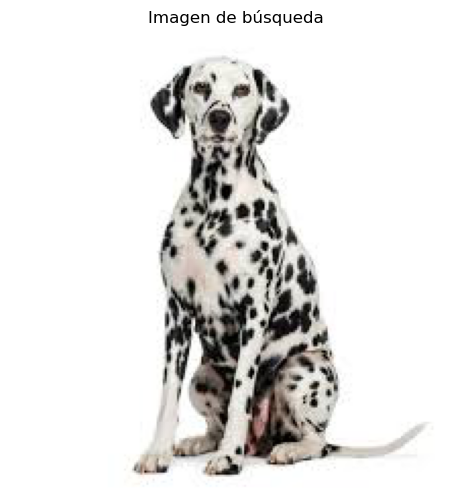

Extrayendo características...
Buscando perros similares...

Resultados de la búsqueda: 3 coincidencias encontradas

Coincidencia #1
ID: 12
Similitud: 100.00%
Nombre: dalmata.jpeg
Ubicación: Desconocida
Fecha: 2025-04-20 17:02:53.577647


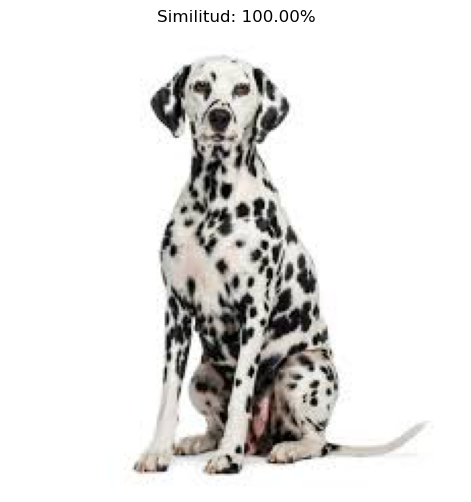


Coincidencia #2
ID: 8
Similitud: 58.91%
Nombre: dalmatamix2.jpeg
Ubicación: Desconocida
Fecha: 2025-04-20 17:02:53.453368


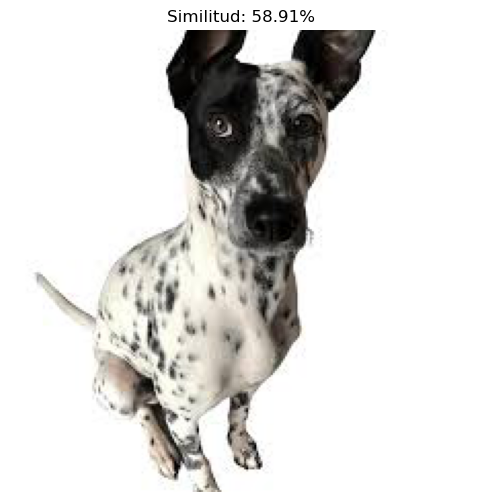


Coincidencia #3
ID: 15
Similitud: 54.96%
Nombre: dalmataMix1.jpeg
Ubicación: Desconocida
Fecha: 2025-04-20 17:02:53.679921


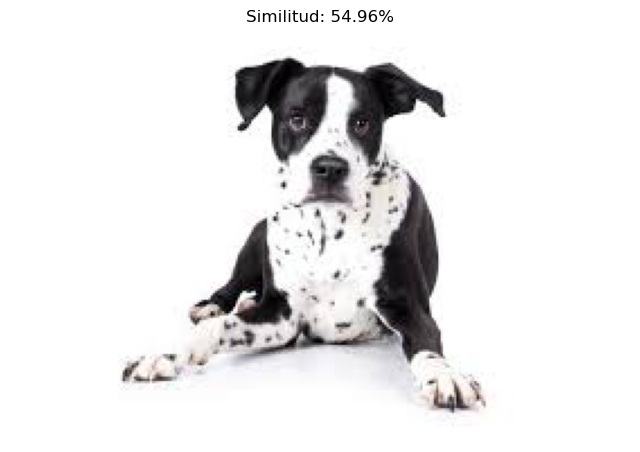

In [70]:
# Puedes cambiar esta imagen por cualquier otra que quieras probar
search_image = '../test_images/Dalmata.jpeg'

if os.path.exists(search_image):  #Se verifica si la imagen de búsqueda existe.
    # Mostrar la imagen de búsqueda
    print('Imagen de búsqueda:')
    show_image(search_image, 'Imagen de búsqueda')
    
    # Extraer características
    print('Extrayendo características...')
    features = model.process_image(search_image) #Se utiliza el modelo de reconocimiento (model) para extraer las características de la imagen de búsqueda.

    
    # Buscar similares
    print('Buscando perros similares...')
    #Se llama a la función search_similar_dogs con las características extraídas y un umbral de similitud de 0.5 para encontrar perros similares en la base de datos.
    results = search_similar_dogs(features, threshold=0.5)
    
    # Mostrar resultados
    print(f'\nResultados de la búsqueda: {len(results)} coincidencias encontradas')
    
    # Mostrar los 5 mejores resultados
    for i, result in enumerate(results[:5]):
        print(f"\nCoincidencia #{i+1}")
        print(f"ID: {result['id']}")
        print(f"Similitud: {result['similarity']:.2%}")
        print(f"Nombre: {result['name']}")
        print(f"Ubicación: {result['location']}")
        print(f"Fecha: {result['found_date']}")
        
        # Mostrar la imagen encontrada
        #Se muestra la imagen del perro encontrado en la base de datos junto con su puntuación de similitud como título.
        show_image(result['image_path'], f"Similitud: {result['similarity']:.2%}") 
else:
    print(f'No se encontró la imagen de búsqueda: {search_image}')